# Reinforcement Learning: Grid World Navigation

## Problem Statement:
In this Reinforcement Learning task, we will train an agent to navigate a 5x5 grid world. The agent starts from a random position and needs to find the optimal path to reach the goal while avoiding penalties. 

### Key Points:
- The grid has obstacles that the agent should avoid.
- The agent receives a positive reward when it reaches the goal.
- The agent receives a negative reward if it hits an obstacle or goes out of bounds.
- The agent will learn to maximize its cumulative reward over time by exploring the grid and learning the optimal strategy (policy) using Q-Learning.

### Goal:
- Train the agent to find the shortest and safest path from any starting position to the goal.
- Implement and demonstrate a simple Q-Learning algorithm to achieve this.

---

## Steps Covered in the Notebook:
1. **Environment Setup**:
    - Define the 5x5 grid world with a goal and obstacles.
    - Initialize the agent's starting position randomly.

2. **Reward System**:
    - Set rewards for reaching the goal (+100), hitting obstacles (-100), and each move (-1 for every step to encourage finding the shortest path).

3. **Q-Learning Algorithm**:
    - Define the Q-table, learning rate, and discount factor.
    - Implement the Q-Learning update rule.

4. **Training the Agent**:
    - Set up the agent to train over several episodes.
    - Allow the agent to explore the grid, learn from its mistakes, and improve its decision-making.

5. **Testing**:
    - After training, place the agent at random starting positions and observe its ability to find the optimal path to the goal.

6. **Visualization**:
    - Visualize the agent's path in the grid after training.
    - Show how the agent avoids obstacles and reaches the goal efficiently.

---

## Q-Learning Concepts Used:
- **Q-Table**: A matrix where each state-action pair is mapped to a value that represents the expected future reward.
- **Learning Rate (α)**: Determines how much the agent updates its knowledge with each step.
- **Discount Factor (γ)**: Balances short-term vs. long-term rewards.
- **Exploration vs Exploitation**: Trade-off between trying new actions (exploration) and using known actions to maximize reward (exploitation).


# Step 1: Environment Setup

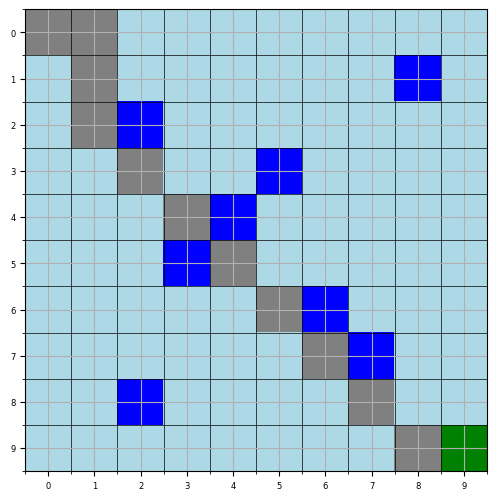

In [42]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors

# Define the grid world dimensions
GRID_SIZE = 10

# Define the grid environment with a goal (G), obstacles (O), and starting point (S)
env = np.zeros((GRID_SIZE, GRID_SIZE))
start_position = (0, 0)
goal_position = (9, 9)  # Goal is placed at the bottom-right corner

# Add more obstacles for the 10x10 grid
obstacles = [(2, 2), (3, 5), (5, 3), (6, 6), (7, 7), (4, 4), (1, 8), (8, 2)]

# Mark the start, goal, and obstacles in the environment
env[start_position] = 3  # Start (Yellow)
env[goal_position] = 2  # Goal (Green)
for obstacle in obstacles:
    env[obstacle] = -1  # Obstacles (Blue)

# Create a custom colormap for Start (Yellow), Goal (Green), Obstacles (Blue), Path (Gray), and Empty cells (Light blue)
cmap = colors.ListedColormap(['blue', 'lightblue', 'yellow', 'green', 'gray'])

# Function to visualize the grid world with the agent's path
def show_grid_with_path(env, path):
    env_copy = np.copy(env)  # Copy the environment to avoid modifying the original
    # Mark the agent's path on the grid
    for step in path:
        if env_copy[step] == 0:  # Only mark the path on empty cells
            env_copy[step] = 4  # Mark path with gray
    
    plt.figure(figsize=(6, 6))  # Adjust figure size for the smaller grid
    plt.imshow(env_copy, cmap=cmap, interpolation='nearest')  # Use 'nearest' to avoid smoothing
    plt.grid(True)
    
    # Set ticks to show the correct grid lines
    plt.xticks(ticks=np.arange(0, GRID_SIZE, 1), labels=np.arange(0, GRID_SIZE, 1), fontsize=6)
    plt.yticks(ticks=np.arange(0, GRID_SIZE, 1), labels=np.arange(0, GRID_SIZE, 1), fontsize=6)
    
    # Add the grid lines
    plt.gca().set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=0.5)  # Use smaller grid lines
    
    # Set the limits to avoid cutting off the edges
    plt.xlim(-0.5, GRID_SIZE-0.5)
    plt.ylim(GRID_SIZE-0.5, -0.5)
    
    plt.show()

# Example of agent's path (replace this with the actual path from your trained agent)
example_path = [(0, 0), (0, 1), (1, 1), (2, 1), (3, 2), (4, 3), (5, 4), 
                (6, 5), (7, 6), (8, 7), (9, 8), (9, 9)]  # Updated path for 10x10 grid

# Visualize the grid with the agent's path
show_grid_with_path(env, example_path)


# Step 2: Reward System

In [43]:
# Define the rewards for actions
rewards = np.full((GRID_SIZE, GRID_SIZE), -1)  # Penalty for each move
rewards[goal_position] = 100  # Reward for reaching the goal

for obstacle in obstacles:
    rewards[obstacle] = -100  # Penalty for hitting an obstacle

# Show the reward table
print("Reward Table:")
print(rewards)


Reward Table:
[[  -1   -1   -1   -1   -1   -1   -1   -1   -1   -1]
 [  -1   -1   -1   -1   -1   -1   -1   -1 -100   -1]
 [  -1   -1 -100   -1   -1   -1   -1   -1   -1   -1]
 [  -1   -1   -1   -1   -1 -100   -1   -1   -1   -1]
 [  -1   -1   -1   -1 -100   -1   -1   -1   -1   -1]
 [  -1   -1   -1 -100   -1   -1   -1   -1   -1   -1]
 [  -1   -1   -1   -1   -1   -1 -100   -1   -1   -1]
 [  -1   -1   -1   -1   -1   -1   -1 -100   -1   -1]
 [  -1   -1 -100   -1   -1   -1   -1   -1   -1   -1]
 [  -1   -1   -1   -1   -1   -1   -1   -1   -1  100]]


# Step 3: Q-Learning Algorithm

In [44]:
# Initialize Q-table
q_table = np.zeros((GRID_SIZE, GRID_SIZE, 4))  # Four possible actions (up, down, left, right)

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration factor
num_episodes = 1000

# Define possible actions
actions = ['up', 'down', 'left', 'right']
action_mapping = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

# Function to choose action (exploration vs exploitation)
def choose_action(state):
    if random.uniform(0, 1) < epsilon:  # Exploration
        return random.choice(actions)
    else:  # Exploitation
        return actions[np.argmax(q_table[state[0], state[1]])]


# Step 4: Training the Agent

In [45]:
# Function to move the agent in the grid
def take_action(state, action):
    delta = action_mapping[action]
    new_state = (state[0] + delta[0], state[1] + delta[1])
    if 0 <= new_state[0] < GRID_SIZE and 0 <= new_state[1] < GRID_SIZE:
        return new_state
    else:
        return state  # Stay in the same position if out of bounds

# Training loop
for episode in range(num_episodes):
    state = (random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1))  # Random start
    done = False

    while not done:
        action = choose_action(state)
        next_state = take_action(state, action)
        reward = rewards[next_state]
        
        # Q-Learning update rule
        best_future_q = np.max(q_table[next_state[0], next_state[1]])
        q_table[state[0], state[1], actions.index(action)] += alpha * (reward + gamma * best_future_q - q_table[state[0], state[1], actions.index(action)])

        state = next_state
        if state == goal_position:
            done = True

print("Training completed!")

Training completed!


# Step 5: Testing the Agent

In [46]:
# Function to test the agent's path
def test_agent():
    state = (0, 0)  # Fixed start at (0, 0)
    # state = (random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1))  # Random start
    path = [state]
    
    while state != goal_position:
        action = actions[np.argmax(q_table[state[0], state[1]])]
        state = take_action(state, action)
        path.append(state)
    
    return path

# Test the agent's path
path = test_agent()
print("Agent's path:", path)


Agent's path: [(0, 0), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 4), (2, 5), (2, 6), (2, 7), (3, 7), (4, 7), (4, 8), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]


# Step 6: Visualization

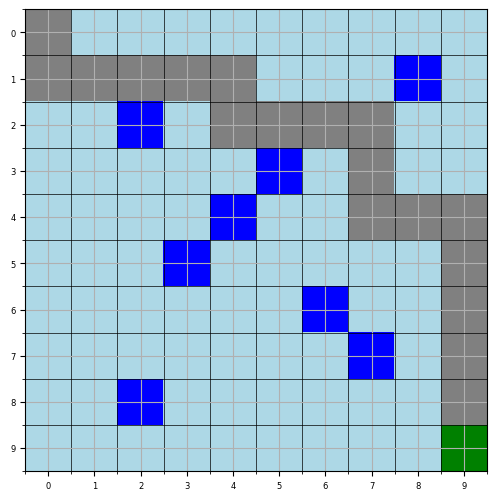

In [47]:
def visualize_path(path):
    env_copy = np.copy(env)  # Make a copy to avoid modifying the original environment
    
    # Mark the agent's path on the copied environment
    for step in path:
        if env_copy[step] == 0:  # Only mark the path on empty cells (avoid marking obstacles and goal)
            env_copy[step] = 4  # Set to 4 to map to gray in the colormap
    
    # Reuse the show_grid_with_path function for visualization
    show_grid_with_path(env_copy, path)


# Visualize the grid with the agent's path
visualize_path(path)



# Adding scope of Diagonal Movement

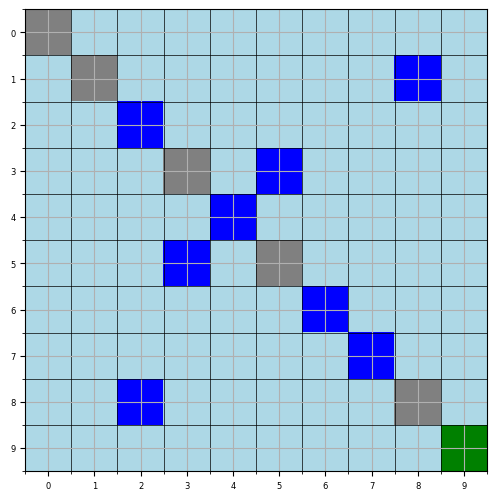

In [48]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors

# Define the grid world dimensions
GRID_SIZE = 10

# Define the grid environment with a goal (G), obstacles (O), and starting point (S)
env = np.zeros((GRID_SIZE, GRID_SIZE))
start_position = (0, 0)
goal_position = (9, 9)  # Goal is placed at the bottom-right corner

# Add more obstacles for the 10x10 grid
obstacles = [(2, 2), (3, 5), (5, 3), (6, 6), (7, 7), (4, 4), (1, 8), (8, 2)]

# Mark the start, goal, and obstacles in the environment
env[start_position] = 3  # Start (Yellow)
env[goal_position] = 2  # Goal (Green)
for obstacle in obstacles:
    env[obstacle] = -1  # Obstacles (Blue)

# Create a custom colormap for Start (Yellow), Goal (Green), Obstacles (Blue), Path (Gray), and Empty cells (Light blue)
cmap = colors.ListedColormap(['blue', 'lightblue', 'yellow', 'green', 'gray'])

# Action space now includes diagonal movements: up, down, left, right, and 4 diagonals
actions = ['up', 'down', 'left', 'right', 'up-left', 'up-right', 'down-left', 'down-right']
action_mapping = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
    'up-left': (-1, -1),
    'up-right': (-1, 1),
    'down-left': (1, -1),
    'down-right': (1, 1)
}

# Function to take an action and move the agent in the grid
def take_action(state, action):
    delta = action_mapping[action]
    new_state = (state[0] + delta[0], state[1] + delta[1])
    
    # Ensure the new state is within grid bounds
    if 0 <= new_state[0] < GRID_SIZE and 0 <= new_state[1] < GRID_SIZE:
        return new_state
    else:
        return state  # Stay in the same position if out of bounds

# Function to visualize the grid world with the agent's path
def show_grid_with_path(env, path):
    env_copy = np.copy(env)  # Copy the environment to avoid modifying the original
    # Mark the agent's path on the grid
    for step in path:
        if env_copy[step] == 0:  # Only mark the path on empty cells
            env_copy[step] = 4  # Mark path with gray
    
    plt.figure(figsize=(6, 6))  # Adjust figure size for the smaller grid
    plt.imshow(env_copy, cmap=cmap, interpolation='nearest')  # Use 'nearest' to avoid smoothing
    plt.grid(True)
    
    # Set ticks to show the correct grid lines
    plt.xticks(ticks=np.arange(0, GRID_SIZE, 1), labels=np.arange(0, GRID_SIZE, 1), fontsize=6)
    plt.yticks(ticks=np.arange(0, GRID_SIZE, 1), labels=np.arange(0, GRID_SIZE, 1), fontsize=6)
    
    # Add the grid lines
    plt.gca().set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=0.5)  # Use smaller grid lines
    
    # Set the limits to avoid cutting off the edges
    plt.xlim(-0.5, GRID_SIZE-0.5)
    plt.ylim(GRID_SIZE-0.5, -0.5)
    
    plt.show()

# Example of agent's path including diagonal movement (replace this with the actual path from your trained agent)
example_path = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), 
                (6, 6), (7, 7), (8, 8), (9, 9)]  # Including diagonal steps

# Visualize the grid with the agent's path
show_grid_with_path(env, example_path)


In [49]:
# Initialize Q-table with 8 possible actions (up, down, left, right, and 4 diagonals)
q_table = np.zeros((GRID_SIZE, GRID_SIZE, len(actions)))  # Now there are 8 actions

# Hyperparameters for Q-learning
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 1000

# Function to choose an action based on epsilon-greedy strategy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:  # Exploration
        return random.choice(actions)
    else:  # Exploitation: choose action with max Q-value
        return actions[np.argmax(q_table[state[0], state[1]])]


In [50]:
# Training loop for Q-learning
for episode in range(num_episodes):
    state = start_position  # Start from the fixed starting position (0, 0)
    done = False
    
    while not done:
        action = choose_action(state)
        next_state = take_action(state, action)
        
        # Get reward for the new state
        if next_state == goal_position:
            reward = 100  # Reward for reaching the goal
            done = True
        elif env[next_state] == -1:  # If the agent hits an obstacle
            reward = -100  # Penalty for hitting obstacles
            done = True
        else:
            reward = -1  # Small penalty for each step to encourage shorter paths
        
        # Q-learning update rule
        best_future_q = np.max(q_table[next_state[0], next_state[1]])  # Max Q-value for the next state
        q_table[state[0], state[1], actions.index(action)] += alpha * (reward + gamma * best_future_q - q_table[state[0], state[1], actions.index(action)])
        
        state = next_state  # Move to the next state

    if episode % 100 == 0:
        print(f"Episode {episode} completed.")
        
print("Training completed!")


Episode 0 completed.
Episode 100 completed.
Episode 200 completed.
Episode 300 completed.
Episode 400 completed.
Episode 500 completed.
Episode 600 completed.
Episode 700 completed.
Episode 800 completed.
Episode 900 completed.
Training completed!


In [51]:
# Function to test the agent's path after training
def test_agent():
    state = start_position  # Start at (0, 0)
    path = [state]
    
    while state != goal_position:
        action = actions[np.argmax(q_table[state[0], state[1]])]  # Choose the best action from the Q-table
        state = take_action(state, action)
        path.append(state)
    
    return path

# Test the agent's path after training
best_path = test_agent()
print("Best path:", best_path)


Best path: [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 8), (8, 9), (9, 9)]


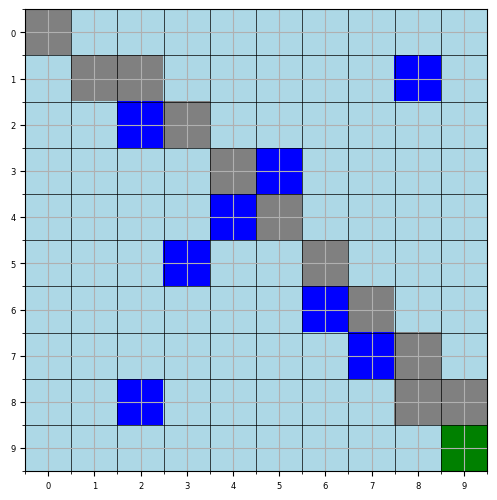

In [52]:
# Visualization of the agent's best path after training
def visualize_best_path(path):
    env_copy = np.copy(env)  # Copy the environment to avoid modifying the original
    
    # Mark the agent's best path on the grid
    for step in path:
        if env_copy[step] == 0:  # Only mark the path on empty cells
            env_copy[step] = 4  # Mark path with gray
    
    # Visualize the grid with path
    show_grid_with_path(env_copy, path)

# Visualize the best path after training
visualize_best_path(best_path)
